In [1]:
import numpy as np
import pandas as pd
import os
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
from adjustText import adjust_text


In [ ]:
from module.convect.entropy_prep import get_ud_all_ent
from module.convect.vectorisation import get_all_vectorisation
from module.vnc_vectorisation_utils import label_point

In [2]:
save_things = True # set as True to save the figures...

if save_things:
    supplementary_path = '../figures/supplementary'
    if not os.path.isdir(supplementary_path):
        os.makedirs(supplementary_path)


# _Drosophila_ VNC



## Load data


In [3]:
datadate = '20241119' # date of drosophila VNC data pull

dm_datadir = f'../data/{datadate}_dm_data'
if not os.path.isdir(dm_datadir):
    os.mkdir(dm_datadir)

if not os.path.isdir(dm_datadir + '/processed'):
    os.mkdir(dm_datadir + '/processed')


In [4]:

df = pd.read_csv(f"{dm_datadir}/manc_edges_{datadate}.csv", index_col=0) # edge data frame
meta_df = pd.read_csv(f"{dm_datadir}/manc_meta_{datadate}.csv", index_col=0) # meta data data frame

df = df.groupby(['bodyId_pre', 'bodyId_post'], as_index=False).weight.sum()
df.loc[:, 'bodyId_post'] = df['bodyId_post'].apply(int)
df.loc[:, 'bodyId_pre'] = df['bodyId_pre'].apply(int)
meta_df.loc[:, 'bodyId'] = meta_df.bodyId.apply(int)

## Hemilineage vectorisation and specialization diversity

In [5]:
h_cat_string = 'hemilineage'
hemilineage_fileprefix = f'{dm_datadir}/processed/hemilineage'

h_cat_meta = meta_df[['bodyId', h_cat_string]].rename(columns={'bodyId':'id', h_cat_string:'type'}).copy(True)

categories = [str(category) for category in h_cat_meta.dropna().type.unique()] 
categories.remove('TBD')
all_hemi_vectors = get_all_vectorisation(df=df, meta_df=h_cat_meta, Ids=None, categories=categories, fpath_prefix=hemilineage_fileprefix, entropy=True)

# ~4.5 mins

../data/20241119_dm_data/processed/hemilineage_vec.parquet vector parquet exists.


In [6]:
# Hemilineage vectorisation specialization-diversity
all_hemi_entropies = get_ud_all_ent(df=df, meta_df=h_cat_meta, categories=categories, fpath_prefix=hemilineage_fileprefix)

# ~4.5 mins

../data/20241119_dm_data/processed/hemilineage_ud_ents.parquet upstream/downstream parquet csv exists.


## Network degrees


In [7]:
edges = df.copy(True)
edges['attr'] = [{'weight':i} for i in edges['weight']]


edge_list = edges[['bodyId_pre', 'bodyId_post', 'attr']].to_numpy()


vnc_g = nx.DiGraph()
vnc_g.add_edges_from(edge_list)

out_deg_cent = nx.out_degree_centrality(vnc_g)
in_deg_cent = nx.in_degree_centrality(vnc_g)
deg_cent = nx.degree_centrality(vnc_g)

strength = dict(nx.degree(vnc_g, weight='weight'))
# to_plot = meta_df.copy(True).reset_index()

meta_df['out_deg']= meta_df.apply(lambda x: out_deg_cent.get(x.bodyId), axis=1)
meta_df['in_deg'] = meta_df.apply(lambda x: in_deg_cent.get(x.bodyId), axis=1)
meta_df['deg'] = meta_df.apply(lambda x: deg_cent.get(x.bodyId), axis=1)
meta_df['strength'] = meta_df.apply(lambda x: strength.get(x.bodyId), axis=1)


## Plot distribution

In [8]:
cmap = mpl.colormaps['tab10']

In [9]:
plot_df = meta_df.copy(True)
plot_df = plot_df.join(all_hemi_entropies, on='bodyId')
plot_df['class'] = plot_df['class'].astype(str)


In [10]:
class_filtered_df = plot_df[~plot_df['class'].isin(['glia','TBD', 'nan', 'Unknown', None])].copy(True)


In [11]:
cclasses=['descending neuron', 'sensory neuron', 'motor neuron', 'intrinsic neuron', 'ascending neuron']
toplot_class_filtered_df= class_filtered_df[class_filtered_df['class'].isin(cclasses)]


In [12]:
entropy_hubs = all_hemi_entropies[f'out_diff_ds'] + all_hemi_entropies[f'in_diff_us']
entropy_hubs = entropy_hubs.sort_values(ascending=False)
entropy_hubs = entropy_hubs.iloc[:10].index.values

ent_hub_df = toplot_class_filtered_df[toplot_class_filtered_df.bodyId.isin(entropy_hubs)].copy(True)



In [13]:
plot_df = meta_df.copy(True)
plot_df = plot_df.join(all_hemi_entropies, on='bodyId')
plot_df['class'] = plot_df['class'].astype(str)
class_filtered_df = plot_df[~plot_df['class'].isin(['glia','TBD', 'nan', 'Unknown', None])].copy(True)


In [14]:
cclasses=['descending neuron', 'sensory neuron', 'motor neuron', 'intrinsic neuron', 'ascending neuron']
toplot_class_filtered_df= class_filtered_df[class_filtered_df['class'].isin(cclasses)]


In [15]:
entropy_hubs = all_hemi_entropies[f'out_diff_ds'] + all_hemi_entropies[f'in_diff_us']
entropy_hubs = entropy_hubs.sort_values(ascending=False)
entropy_hubs = entropy_hubs.iloc[:10].index.values

ent_hub_df = toplot_class_filtered_df[toplot_class_filtered_df.bodyId.isin(entropy_hubs)].copy(True)


In [16]:

# motor function to hemilineage mapping from Harris et al., (2015)
func_hemi_map = {'posture':['03B', '23B', '12B', '13B', '05B', '20A.22A', '08A', '09A'], \
                 'uc_leg_movement':['06A', '06B', '19A', '21A', '23B'], \
                 'walking':['18B', '12A', '01A', '10B'],\
                 'wing_wave':['12A', '03B'],
                 'wing_buzz':['07B', '11A', '11B', '02A', '18B', '12A'], \
                 'takeoff': ['07B', '11A', '11B', '18B'] }

functional_labels = dict(zip(list(func_hemi_map.keys()), range(len(func_hemi_map))))

In [17]:
hemi_func_map = {}
for key, val in func_hemi_map.items():
    for h in val:
        lst = hemi_func_map.get(h, [])
        lst.append(key)
        hemi_func_map[h] = lst


In [18]:
toplot_class_secondary_filtered_df = toplot_class_filtered_df[toplot_class_filtered_df.birthtime=='secondary'].copy(True)

In [19]:
mean_sds = pd.DataFrame([toplot_class_secondary_filtered_df.groupby('hemilineage').out_diff_ds.mean().sort_values(ascending=False), toplot_class_secondary_filtered_df.groupby('hemilineage').in_diff_us.mean().sort_values(ascending=False)]).T


In [20]:
cmap = mpl.colormaps['tab10']
func_hemis = list(set(hemi_func_map.keys()))
non_func_hemis = list(set(mean_sds.index) - set(func_hemis))

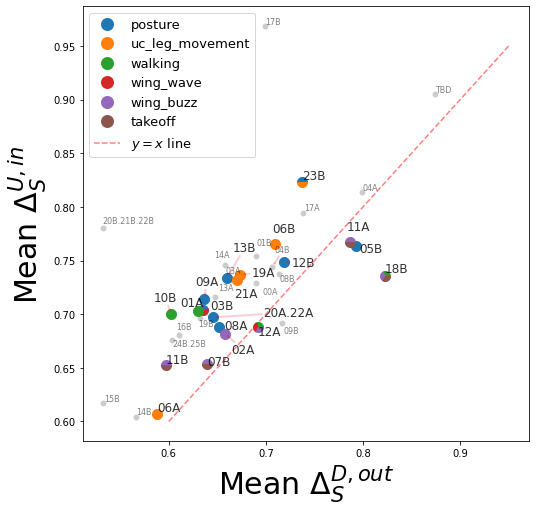

In [22]:
mean_sds = pd.DataFrame([toplot_class_secondary_filtered_df.groupby('hemilineage').out_diff_ds.mean().sort_values(ascending=False), toplot_class_secondary_filtered_df.groupby('hemilineage').in_diff_us.mean().sort_values(ascending=False)]).T

fig, ax = plt.subplots(figsize=(8,8))

sns.scatterplot(mean_sds, x='out_diff_ds', y='in_diff_us', alpha=0.2, color='black', ax=ax) # plot all in transparent black


# plot the functional hemilineages from Harris et al., in colours
for key, val in hemi_func_map.items():
    x, y = mean_sds.loc[key]['out_diff_ds'], mean_sds.loc[key]['in_diff_us']
    cmap_inds = [functional_labels.get(i) for i in val]

    # make an evenly spaced pie chart of markers depending on which function a hemilineage is related to
    num_of_splits = len(val)
    rs = 1/num_of_splits # ratios
    marker_xys = []

    for i in range(num_of_splits):
        marker_x = [0] + np.cos(np.linspace(2 * np.pi * rs * i, 2 * np.pi * rs * (i + 1), 50)).tolist() + [0]
        marker_y = [0] + np.sin(np.linspace(2 * np.pi * rs * i, 2 * np.pi * rs * (i + 1), 50)).tolist() + [0]
        marker_xy = np.column_stack([marker_x, marker_y])
        marker_xys.append(marker_xy)

    for i in range(num_of_splits):
        ax.scatter(x, y, marker=marker_xys[i],
                s=100, facecolor=cmap(cmap_inds[i]))

label_point(mean_sds.loc[func_hemis].reset_index()[f'out_diff_ds'], 
            mean_sds.loc[func_hemis].reset_index()[f'in_diff_us'], 
            mean_sds.loc[func_hemis].reset_index()['hemilineage'], 
            plt.gca(), alpha=0.8, fontsize=12)
label_point(mean_sds.loc[non_func_hemis].reset_index()[f'out_diff_ds'], 
            mean_sds.loc[non_func_hemis].reset_index()[f'in_diff_us'], 
            mean_sds.loc[non_func_hemis].reset_index()['hemilineage'], 
            plt.gca(), alpha=0.5, fontsize=8)

texts = list(plt.gca().texts)

# adjust the text so it's not overlapping:
adjust_text(texts,expand=(1.2, 1.5), min_arrow_len=10, arrowprops=dict(linewidth=2, arrowstyle='->', color='#e2102233'))
xlabel = r'Mean $\Delta_S^{D, out}$'
plt.xlabel(xlabel,size=30 )
legend_elements = [Line2D([0], [0], marker='o', label=key, color=cmap(val), linestyle='',
                          markersize=10, markeredgewidth=3) for key, val in functional_labels.items()] + \
                    [Line2D([0], [0], label=r'$y=x$ line', color='r', linestyle='--', alpha=0.5)] 

ax.legend(handles=legend_elements, fontsize=13)
ax.plot([0.6, 0.95], [0.6, 0.95], 'r--', alpha=0.5)

ylabel = r'Mean $\Delta_S^{U, in}$'
plt.ylabel(ylabel ,size=30 )
if save_things:
    plt.savefig('../figures/supplementary/sd_hemi_avg_secondary_drosophila.png', dpi=300)
plt.show()
